<a href="https://colab.research.google.com/github/San-lab-ship/modelo-clasificacion-planes-moviles/blob/main/modelo-clasificacion-megaline-graficas.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix


In [4]:
from google.colab import files
uploaded = files.upload()
df = pd.read_csv('users_behavior.csv')
df.head()


Saving users_behavior.csv to users_behavior (2).csv


,calls,minutes,messages,mb_used,is_ultra
0,40.0,311.90,83.0,19915.42,0
1,85.0,516.75,56.0,22696.96,0
2,77.0,467.66,86.0,21060.45,0
3,106.0,745.53,81.0,8437.39,1
4,66.0,418.74,1.0,14502.75,0


In [6]:
features = df.drop('is_ultra', axis=1)
target = df['is_ultra']

# División en entrenamiento (60%), validación (20%) y prueba (20%)
features_train, features_temp, target_train, target_temp = train_test_split(
    features, target, test_size=0.4, random_state=42, stratify=target)

features_valid, features_test, target_valid, target_test = train_test_split(
    features_temp, target_temp, test_size=0.5, random_state=42, stratify=target_temp)


In [7]:
# Árboles de decisión con distintas profundidades
for depth in [3, 5, 7, 10, 15]:
    tree = DecisionTreeClassifier(max_depth=depth, random_state=42)
    tree.fit(features_train, target_train)
    predictions = tree.predict(features_valid)
    accuracy = accuracy_score(target_valid, predictions)
    print(f"DecisionTree (depth={depth}): {accuracy:.4f}")

# Bosques aleatorios
for n in [10, 50, 100, 200]:
    forest = RandomForestClassifier(n_estimators=n, random_state=42)
    forest.fit(features_train, target_train)
    predictions = forest.predict(features_valid)
    accuracy = accuracy_score(target_valid, predictions)
    print(f"RandomForest (n={n}): {accuracy:.4f}")

# Regresión logística
log_model = LogisticRegression(solver='liblinear', random_state=42)
log_model.fit(features_train, target_train)
predictions = log_model.predict(features_valid)
print(f"LogisticRegression: {accuracy_score(target_valid, predictions):.4f}")


DecisionTree (depth=3): 0.8040
DecisionTree (depth=5): 0.7900
DecisionTree (depth=7): 0.7885
DecisionTree (depth=10): 0.7698
DecisionTree (depth=15): 0.7465
RandomForest (n=10): 0.7838
RandomForest (n=50): 0.8025
RandomForest (n=100): 0.8009
RandomForest (n=200): 0.8009
LogisticRegression: 0.7030


In [8]:
best_model = RandomForestClassifier(n_estimators=50, random_state=42)
best_model.fit(features_train, target_train)

# Validación
valid_preds = best_model.predict(features_valid)
print("Exactitud validación:", accuracy_score(target_valid, valid_preds))

# Prueba
test_preds = best_model.predict(features_test)
print("Exactitud prueba:", accuracy_score(target_test, test_preds))

# Matriz de confusión
print("Matriz de confusión:\n", confusion_matrix(target_test, test_preds))


Exactitud validación: 0.80248833592535
Exactitud prueba: 0.80248833592535
Matriz de confusión:
 [[401  45]
 [ 82 115]]


In [9]:
# Sensibilidad a variaciones pequeñas
base = pd.DataFrame({'calls': [60], 'minutes': [400], 'messages': [10], 'mb_used': [15000]})
print("Predicción base:", best_model.predict(base))

base_v2 = pd.DataFrame({'calls': [61], 'minutes': [405], 'messages': [11], 'mb_used': [15100]})
print("Predicción con variación leve:", best_model.predict(base_v2))

# Consistencia con perfiles similares
similar_users = pd.DataFrame({
    'calls': [40]*5,
    'minutes': [300]*5,
    'messages': [20]*5,
    'mb_used': [10000]*5
})
print("Predicciones perfiles similares:", best_model.predict(similar_users))


Predicción base: [0]
Predicción con variación leve: [0]
Predicciones perfiles similares: [0 0 0 0 0]


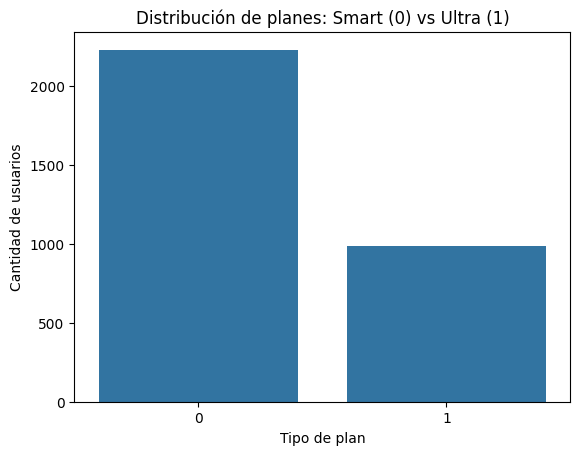

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt

# Gráfico de barras para visualizar cuántos usuarios usan cada plan
sns.countplot(x='is_ultra', data=df)
plt.title('Distribución de planes: Smart (0) vs Ultra (1)')
plt.xlabel('Tipo de plan')
plt.ylabel('Cantidad de usuarios')
plt.show()


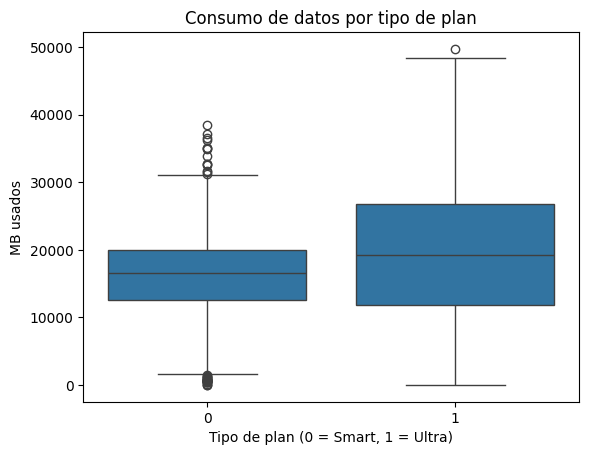

In [11]:
sns.boxplot(x='is_ultra', y='mb_used', data=df)
plt.title('Consumo de datos por tipo de plan')
plt.xlabel('Tipo de plan (0 = Smart, 1 = Ultra)')
plt.ylabel('MB usados')
plt.show()


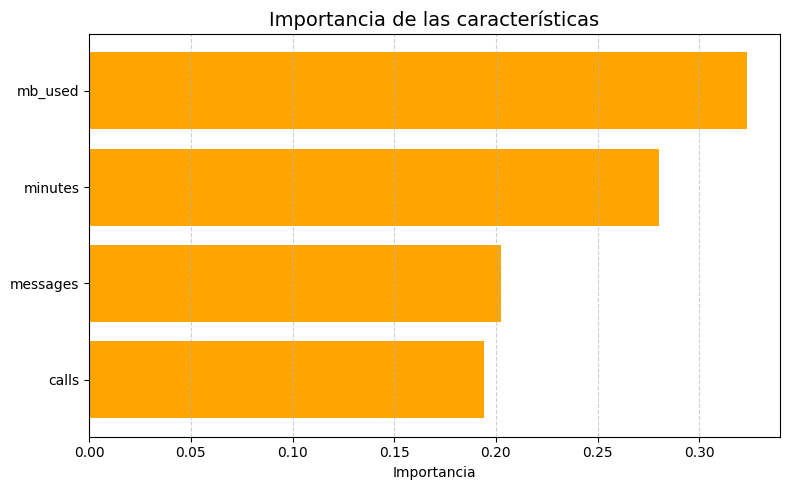

In [17]:
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
import numpy as np

# Entrenamos el modelo
best_forest = RandomForestClassifier(n_estimators=50, random_state=42)
best_forest.fit(X_train, y_train)

# Extraemos la importancia de características
importances = best_forest.feature_importances_
features = X_train.columns
indices = np.argsort(importances)

# Gráfico horizontal con barras naranjas
plt.figure(figsize=(8, 5))
plt.title("Importancia de las características", fontsize=14)
plt.barh(range(len(indices)), importances[indices], color='orange', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel("Importancia")
plt.grid(True, axis='x', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()






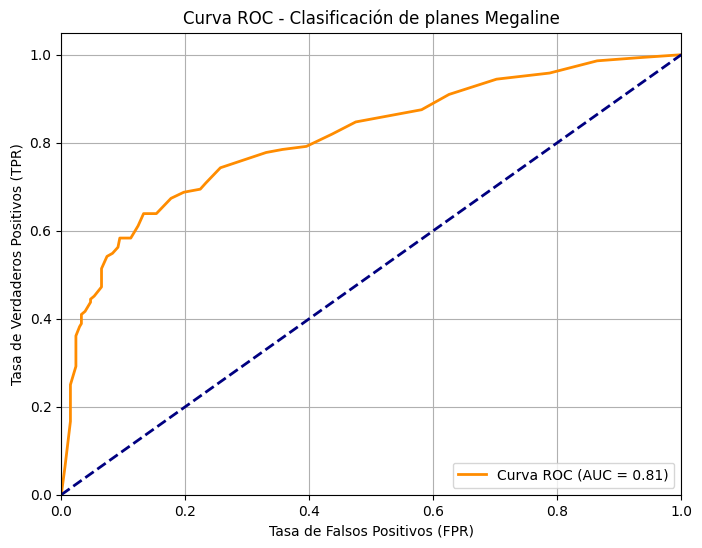

In [18]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Obtener las probabilidades predichas para el conjunto de prueba
y_scores = best_forest.predict_proba(X_test)[:, 1]  # Probabilidad para la clase '1' (Ultra)

# Calcular la curva ROC
fpr, tpr, thresholds = roc_curve(y_test, y_scores)
roc_auc = auc(fpr, tpr)

# Graficar la curva ROC
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'Curva ROC (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
plt.title('Curva ROC - Clasificación de planes Megaline')
plt.legend(loc="lower right")
plt.grid(True)
plt.savefig('roc_curve.png')  # Guarda la gráfica
plt.show()
